[View in Colaboratory](https://colab.research.google.com/github/sahilvora10/Handwritten_Digit/blob/master/handwritten.ipynb)

# **Classify the MNIST handwritten digit dataset**

This code classifies the handwritten digits by MNIST using Keras using Convolution Neural Network.
Keras is a higher level library which operates over either TensorFlow or Theano, and is intended to stream-line the process of building deep learning networks. 

The following  5 blocks are just to run Keras in the Google Collab notebooks.

In [0]:
!pip install -q keras
!pip install -q tqdm

#openCV is used to process and filter images
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17)

In [0]:
from google.colab import auth
auth.authenticate_user()

In [21]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
vcode = getpass.getpass()

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
··········


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# print 'Files in Drive:'
!ls drive/

Here are some libaries that will used in the classification.

In [0]:
from __future__ import print_function, division

import keras as keras
import numpy as np
import random
import os
import glob
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from scipy.misc import imresize, imsave

from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle

from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

Load the Data and process it.

In [0]:
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [103]:
print(X_train.shape)

(60000, 28, 28)


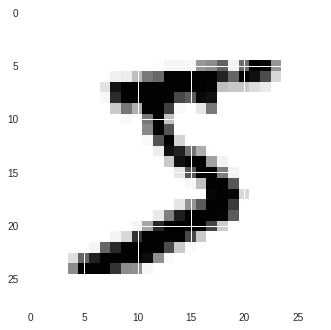

In [104]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

In [0]:

X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [106]:
print(X_train.shape)

(60000, 28, 28, 1)


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [108]:

print(y_train.shape)

(60000,)


In [0]:
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

In [110]:
print(Y_train.shape)

(60000, 10)


In [56]:
from google.colab import files
uploaded = files.upload()

Saving CNN-example-block-diagram.jpg to CNN-example-block-diagram.jpg


Here is the network architecture we are going to build.

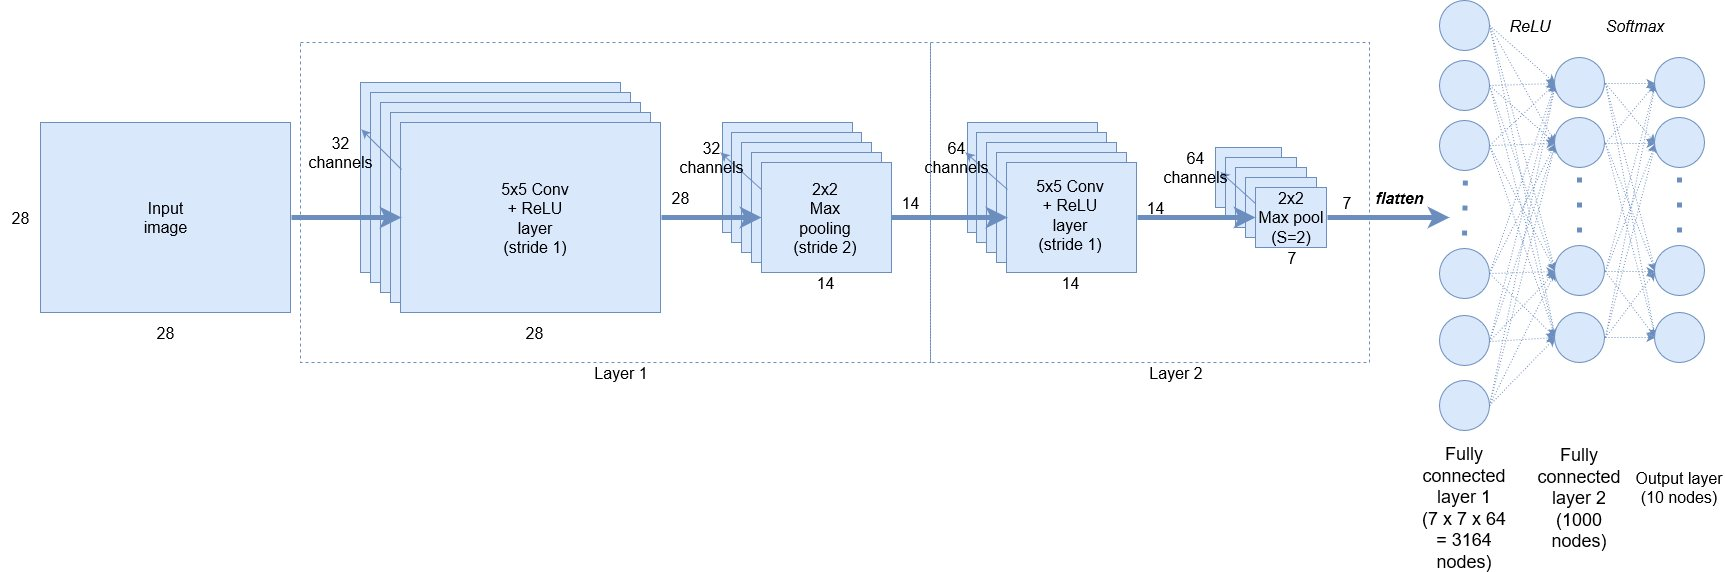

In [62]:

from IPython.display import Image
Image(filename='CNN-example-block-diagram.jpg')

***This is the main architecture buildup.***

In [0]:
batch_size = 128  #batch size – we don’t have to explicitly handle the batching up of our data during training in Keras, 
                  #rather we just specify the batch size and it does it for us ,here we choose 128 as the batch size
num_classes = 10
epochs = 3  #here the number of epochs could be changed and accordingly the iterations would change. 


model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), # here 32 is the number of output layers as you can see from the image above.
                 activation='relu',                      # (5,5) is the filter size and stride amout is (1,1) in (x,y) 
                 input_shape=(28,28,1)))                 # input size is (28,28,1) as shown in figure
#Declaring the input shape is only required of the first layer – Keras is good enough to work out the size of the tensors flowing through the model from there.
#Also notice that we don’t have to declare any weights or bias variables like we do in TensorFlow, Keras sorts that out for us.

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) #Next we add a 2D max pooling layer.
# size of the pooling in the x and y directions – (2, 2) in this case, and the strides.

model.add(Conv2D(64, (5, 5), activation='relu')) #again a convolution layer with number of output layer as 64 #the stride by default is (1,1) so we can leave that.
#we dont need to worry about the input layer,the keras will handle it on its own.
model.add(MaxPooling2D(pool_size=(2, 2))) # max pool it to same size , default stride length

# As you can observe, the output of the final pooling layer is many channels of x x y matrices.  
#To connect the output of the pooling layer to the fully connected layer, we need to flatten this output into a single (N x 1) tensor.
# so for example here there are 64 channels of size 7x7, we need to flatten this to one single coloumn of 7x7x64 rows
model.add(Flatten())

#The next two lines declare our fully connected layers – using the Dense() layer in Keras
model.add(Dense(1000, activation='relu'))  # First we specify the size – in line with our architecture, we specify 1000 nodes, each activated by a ReLU function
model.add(Dense(10, activation='softmax')) # The second is our soft-max classification, or output layer, 
                                           # which is the size of the number of our classes (10 in this case, for our 10 possible hand-written digits).

***Training and evaluating our model on the data.***

We have now developed the architecture of the CNN in Keras, but we haven’t specified the loss function, or told the framework what type of optimiser to use (i.e. gradient descent, Adam optimiser etc.).

In [0]:

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

Keras has a useful utility titled “callbacks” which can be utilised to track all sorts of variables during training.  You can also use it to create checkpoints which saves the model at different stages in training to help you avoid work loss in case your poor overworked computer decides to crash.

In [0]:


class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

***Next, we want to train our model***



1.   We first pass in all of our training data – in this case x_train and y_train
2.   The next argument is the batch size – we don’t have to explicitly handle the batching up of our data during training in Keras, rather we just specify the batch size and it does it for us
3.  The verbose flag, set to 1 here, specifies if you want detailed information being printed in the console about the progress of the training
4. Finally, we pass the validation or test data to the fit function so Keras knows what data to test the metric against when evaluate() is run on the model.
5. Once the model is trained, we can then evaluate it and print the results:





In [124]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 84s 1ms/step - loss: 0.1454 - acc: 0.9565 - val_loss: 0.1231 - val_acc: 0.9631
Epoch 2/3
14720/60000 [======>.......................] - ETA: 59s - loss: 0.1297 - acc: 0.9620

60000/60000 [==============================] - 84s 1ms/step - loss: 0.1203 - acc: 0.9645 - val_loss: 0.0999 - val_acc: 0.9711
Epoch 3/3
40704/60000 [===================>..........] - ETA: 25s - loss: 0.1053 - acc: 0.9690

60000/60000 [==============================] - 84s 1ms/step - loss: 0.1034 - acc: 0.9691 - val_loss: 0.0921 - val_acc: 0.9734
Test loss: 0.09212632613554597
Test accuracy: 0.9734


After 3 epochs, we get an accuracy of 97.34% , but if we increase our epochs to 10, it will result an accuray of 99.2% which is a great success. 

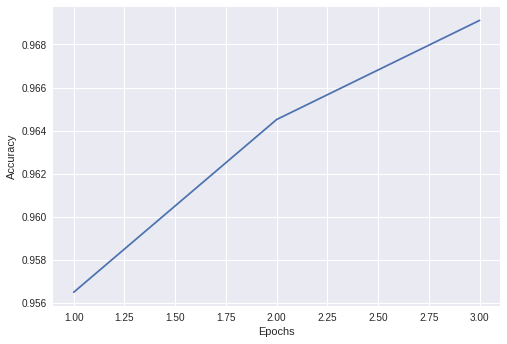

In [126]:
plt.plot(range(1,4), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

you can see the same in the above graph.


In [127]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=10,      #lets check the same for 10 epochs.
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 84s 1ms/step - loss: 0.0917 - acc: 0.9729 - val_loss: 0.0763 - val_acc: 0.9790
Epoch 2/10
14336/60000 [======>.......................] - ETA: 1:01 - loss: 0.0879 - acc: 0.9729

60000/60000 [==============================] - 85s 1ms/step - loss: 0.0829 - acc: 0.9747 - val_loss: 0.0769 - val_acc: 0.9775
Epoch 3/10
40320/60000 [===================>..........] - ETA: 26s - loss: 0.0771 - acc: 0.9763

60000/60000 [==============================] - 85s 1ms/step - loss: 0.0744 - acc: 0.9771 - val_loss: 0.0701 - val_acc: 0.9782
Epoch 4/10
50304/60000 [========================>.....] - ETA: 13s - loss: 0.0681 - acc: 0.9793

60000/60000 [==============================] - 85s 1ms/step - loss: 0.0693 - acc: 0.9789 - val_loss: 0.0802 - val_acc: 0.9738
Epoch 5/10
54016/60000 [==========================>...] - ETA: 8s - loss: 0.0639 - acc: 0.9810

60000/60000 [==============================] - 85s 1ms/step - loss: 0.0640 - acc: 0.9810 - val_loss: 0.0599 - val_acc: 0.9822
Epoch 6/10
55424/60000 [==========================>...] - ETA: 6s - loss: 0.0592 - acc: 0.9820

60000/60000 [==============================] - 85s 1ms/step - loss: 0.0601 - acc: 0.9818 - val_loss: 0.0527 - val_acc: 0.9843
Epoch 7/10
55808/60000 [==========================>...] - ETA: 5s - loss: 0.0564 - acc: 0.9829

60000/60000 [==============================] - 84s 1ms/step - loss: 0.0563 - acc: 0.9828 - val_loss: 0.0856 - val_acc: 0.9699
Epoch 8/10
56192/60000 [===========================>..] - ETA: 5s - loss: 0.0530 - acc: 0.9836

60000/60000 [==============================] - 84s 1ms/step - loss: 0.0528 - acc: 0.9836 - val_loss: 0.0501 - val_acc: 0.9847
Epoch 9/10
56320/60000 [===========================>..] - ETA: 4s - loss: 0.0509 - acc: 0.9845

60000/60000 [==============================] - 83s 1ms/step - loss: 0.0510 - acc: 0.9846 - val_loss: 0.0506 - val_acc: 0.9854
Epoch 10/10
56064/60000 [===========================>..] - ETA: 5s - loss: 0.0481 - acc: 0.9859

60000/60000 [==============================] - 83s 1ms/step - loss: 0.0478 - acc: 0.9859 - val_loss: 0.0452 - val_acc: 0.9865
Test loss: 0.045179938695486636
Test accuracy: 0.9865


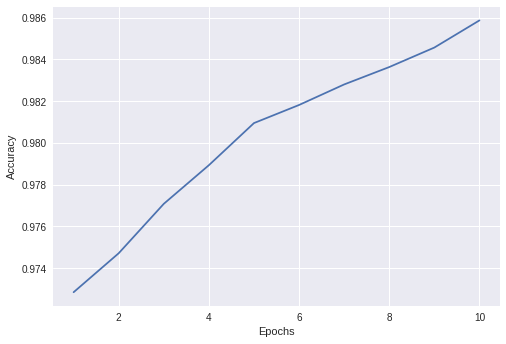

In [128]:
plt.plot(range(1,11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

As you can see an accuracy of 98.65% is great and near-human accuracy.